# <center>Music Prediction and Generation</center>


In this notebook, we present our MIDI-to-genre prediction model and generator, and how to use the notebook to process your own dataset, train it, and generate .mid files with it.

<b>The first thing you want to do is to change the value of `WORKING_DIRECTORY` to the directory which contains the \Data folder</b>. So for example, C:\Users\name\Music Prediction and Synthesis\Data. This should be set as os.getcwd() by default, unless you've downloaded it and ran the notebook elsewhere.

In [ ]:
##make sure to set WORKING_DIRECTORY to where the 'Data' folder is at
WORKING_DIRECTORY = r"C:\Users\harki\MAT180_Final_Project\Data"

Now, to upload your own .mid samples, create a folder with the genre name in \Data, and put the corresponding .mid files in this folder. There are already 18 folders by default of popular genres, so you can put your .mid files in there instead.

# Essential imports and ground constants
Run everything in the following cells to get basic data and imports.

In [ ]:
import os
import json
import mido
from mido import MidiFile
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import plotly
import plotly.graph_objects as go
import random, time
from collections import Counter
from sklearn.model_selection import train_test_split
import json
import math
from sklearn.datasets import fetch_openml
from json import JSONEncoder

##this specifies how deep to search every folder in 'Data'.
FILE_DEPTH = 3

##this specifies how many notes we want to compute later, quantized to sixteenth notes
##so 8 bars in common time is equal to a capacity of 128
CAPACITY = 256

##if our dataset grows, change this to reflect new genres added
##alternatively, we can use the number of keys in genres_dict instead.
UNIQUE_GENRES = 18

# Important preprocessing methods
Run everything below to get necessary methods for preprocessing the data.

In [ ]:
def memoize(f):
    Cache = {}
    
    def f_memoized(*args):
        if (f, args) in Cache:
            return Cache[(f, args)]
        result = f(*args)
        Cache[(f, args)] = result
        return result
    
    return f_memoized

def getNotes(mid,trackNo):
    notes = []
    for msg in mid.tracks[trackNo]:
        if msg.type == 'note_on':
            notes.append(msg)
    return notes  

def getNotesTrack(track):
    notes = []
    for msg in track:
        if msg.type == 'note_on':
            notes.append(msg)
    return notes

def quantize16(notes):
    for i in range(len(notes)):
        if notes[i].velocity == 0 and notes[i].time > 50 and notes[i].time <= 60:
            notes[i] = notes[i].copy(time = 113)
    return notes

def absolutize(notes):
    #this methods returns a dictionary with notes matching the exact time
    for i in range(1,len(notes)):
        notes[i] = notes[i].copy(time = notes[i].time + notes[i-1].time)
    return notes

#input is list of notes, capacity, padding and removeZeroVelocities
def trim(notes,capacity, pad = True, removeZeroVelocities = True):
    trimmed = []
    count = 0
    
    notesToDel = []
    if removeZeroVelocities == True:
        for i in range(len(notes)):
            if notes[i].velocity == 0:
                notesToDel.append(notes[i])
    
    for item in notesToDel:
        notes.remove(item)
    
    
    
    while count < capacity and count < len(notes):
        trimmed.append(notes[count])
        count += 1
    if pad == True:
#         emptyNote = mido.Message('note_on', velocity = 0)
        i = 0
        while len(trimmed) < capacity:
            trimmed.append(notes[i])
            i += 1
            if i >= len(notes):
                i = 0

    return trimmed

# @memoize
def getMidiFile(target):
    path = WORKING_DIRECTORY
    for root, dirs, files in os.walk(path):
        for name in files:
            if name == target:
                targetLocation = os.getcwd()
                filepath = root + os.sep

    os.chdir(filepath)
    return MidiFile(target, clip = True)

#takes a MidiFile and returns only the trimmed notes
def compress(midiFile, pad = True, removeZeroVelocities = True):
    list = []
    for tracks in midiFile.tracks:
        list.append(tracks)
    
    merged = mido.merge_tracks(list)
    merged = getNotesTrack(merged)
    merged = trim(merged, CAPACITY, pad, removeZeroVelocities)
    
    return merged

def encoder(genre):
    length = len(genres_dict.keys())

    list = []

    for keys in genres_dict.keys():
        list.append(keys)
        
    output = np.zeros(len(list))   
    for j in range(len(list)):
        if genre == list[j]:
            output[j] = 1       
    return output

def decoder(array):
    list = []
    for keys in genres_dict.keys():
        list.append(keys)
    index = np.argmax(array)

    return list[index]
 
def genADLData(size):
    list = []
    for key in genres_dict.keys():
        list.append(key)
    genres = []
     
    for i in range(size):
        r = random.randint(0,len(list)-1)
        genres.append(list[r])
    
    music = []
    for item in genres:
        music = music + random.sample(genres_dict[item],1)    
    return genres,music

#gets MidiFiles from a list with str music entires
def getMidiList(musicList):
    for i in range(len(musicList)):
        musicList[i] = getMidiFile(musicList[i])
    return musicList
        
#gets only notes from a list with str music entries
def getNotesFromList(musicList):
    outputList = []
    for i in range(len(musicList)):
        outputList.append( musicList[i].note )
    return outputList

def getTimesFromList(musicList):
    outputList = []
    for i in range(len(musicList)):
        outputList.append( musicList[i].time )
    return outputList

def getVelocitiesFromList(musicList):
    outputList = []
    for i in range(len(musicList)):
        outputList.append( musicList[i].velocity )
    return outputList

def compressListofNames(genre,music):
    outputList = []
    for i in range(len(music)):
        if i > 1 and i % 100 == 0:
            print("Compressed",i,"files so far.")
        try:
            outputList.append( compress(getMidiFile(music[i])) )
        except:
            print(music[i],"caused an error! Ignoring this file for compression.")
            del genre[i]
    return outputList

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

# Forming genres_dict
From the folder 'Data', we create a dictionary `genres_dict` which contains keys as genres and elements of that key as lists of music associated with that genre. If you want to load the entire set which contains corrupted data as well, run the following cell. If you want to use the default samples, skip to <b>Load Uncorrupted Genres_Dict</b>

In [ ]:
# collects midi files from a given folder
def collect_midi_files(midi_files):
    for element in os.listdir():
        if os.path.isdir(os.getcwd() + "/" + element):
            # print(f'folder: {element}')
            os.chdir(os.getcwd() + "/" + element)
            midi_files = collect_midi_files(midi_files)
            os.chdir("..")
        elif element.endswith(".mid"): # change to .mid
            # print(f'file: {element}')
            midi_files.append(element)
    return midi_files

os.chdir(WORKING_DIRECTORY)

genres_dict = {}

for element in os.listdir():
    if os.path.isdir(os.getcwd() + "/" + element):
        os.chdir(os.getcwd() + "/" + element)
        midi_names = []
        midi_names = collect_midi_files(midi_names)
        if midi_names != []:
            genres_dict[element] = midi_names
        os.chdir("..")

print(genres_dict)

count = 0
for keys in genres_dict.keys():
    for list in genres_dict[keys]:
        count += 1
print("\ngenres_dict has",count,"elements")

Like many massive datasets uncautiously curated, there are corrupted data. Below is an example

In [ ]:
#example corrupted Midi file
mid = getMidiFile('Fig Leaf Rag.mid')

This method below removes all corrupted data from genres_dict. Running cleanData() will take approximately an hour.

In [ ]:
# genres_dict = {'Ambient':['Fig Leaf Rag.mid','Edvard Grieg Ich liebe dich.mid']}
@memoize
def cleanData():
    errorCount = 0
    count = 0
    for keys in genres_dict.keys():
        for item in genres_dict[keys]:
            if count%100 == 0 and count > 1:
                print("Went through",count,"files so far.")
            try:
                getMidiFile(item)
            except:
                genres_dict[keys].remove(item)
                errorCount += 1
            count += 1

    count = 0
    for keys in genres_dict.keys():
        for list in genres_dict[keys]:
            count += 1
    print("There were",errorCount,"corrupted files.")
    print("Uncorrupted genres_dict has",count,"files.")

In [ ]:
##takes approximately an hour
cleanData()

# Load Uncorrupted genres_dict
This cell below returns `genres_dict` just like above, but without corrupted files and is much faster. If you are using your own samples, this will not load them, and you will have to perform the operations in the cells above to load your own samples.

In [ ]:
os.chdir(WORKING_DIRECTORY)
os.chdir("..")

with open('uncorrupted.txt') as f:
    data = f.read()

genres_dict = json.loads(data)

print(genres_dict)
count = 0
for keys in genres_dict.keys():
    for list in genres_dict[keys]:
        count += 1
print("\nUncorrupted genres_dict has",count,"elements")

# Neural Network functions

Running the cell below gives you absolutely everything you need for a feedfoward neural network we will use in this notebook.

In [ ]:
# run this cell to import needed modules and define plotting functions (no input needed)
# function to plot costs
def plot_costs(costs):
    plt.plot(costs)
    plt.xlabel("iterations")
    plt.ylabel("cost")
    plt.show()
    
# function to plot costs
def plot_grads(grads):
    plt.plot(grads)
    plt.xlabel("iterations")
    plt.ylabel("gradient norm")
    plt.show()

# defining a function to plot data
def plot_data(X,Y,size_ = 2):
    m = len(X)
    plot_figure = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=[r[0] for r in Y], mode='markers',marker=dict(size=size_))])
    plotly.offline.iplot(plot_figure)

# defining a function to plot models fit
def plot_fit(X,Y,W,B,G,size_ = 2):
    trace = go.Scatter3d(x=X[:,0], y=X[:,1], z=[r[0] for r in Y], mode='markers',marker=dict(size=size_))
    xs,ys = X[:,0],X[:,1]
    xxx = np.outer(np.linspace(min(xs), max(xs), 30), np.ones(30))
    yyy = np.outer(np.linspace(min(ys), max(ys), 30), np.ones(30)).T
    zzz = np.zeros([30,30])
    D = len(G)-1
    for i in range(30):
        for j in range(30):
            zzz[i,j] = feedforward(W,B,G,np.array([xxx[i,j],yyy[i,j]]))[D][0]
    # Configure the layout.
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    data = [trace,go.Surface(x=xxx, y=yyy, z=zzz, showscale=False, opacity=0.5)]
    # Render the plot.
    plot_figure = go.Figure(data=data, layout=layout)
    plot_figure.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=[min(X[:,0]),max(X[:,0])],),
            yaxis = dict(nticks=4, range=[min(X[:,1]),max(X[:,1])],),
            zaxis = dict(nticks=4, range=[min(Y),max(Y)],),),
        width=700,
        margin=dict(r=20, l=10, b=10, t=10))
    plotly.offline.iplot(plot_figure)

def ReLU(x,deriv = False):
    if deriv == True:
        Hx = []
        for element in x:
            if element >= 0:
                Hx = Hx + [1]
            else:
                Hx = Hx + [0]
        return np.diag(np.array(Hx)) 
    else:
        Hx = []
        for element in x:
            if element >= 0:
                Hx = Hx + [element]
            else:
                Hx = Hx + [0]
        return np.array(Hx)

def Linear(x,deriv = False):
    if deriv == True:
        if type(x) != np.ndarray:
            return np.array([1])
        else:
            return np.eye(x.shape[0])
    else:
        Lx = []
        for element in x:
            Lx = Lx + [element]
        return np.array(Lx)

def Sigmoid(x,deriv = False):
    if deriv:
        return np.diag(Sigmoid(x,False)*(1-Sigmoid(x,False)))
    return 1/(1+np.exp(-x))
#     if deriv == True:
#         y = Sigmoid(x,deriv = False)
#         ones = np.ones(y.shape)
#         return np.diag( y*(ones - y) )  
#     else:
#         Sgx = []
#         for element in x:
#             Sgx = Sgx + [1/(1+math.e**(-element))]
#         return np.array(Sgx)

def Squared(x,deriv = False):
    if deriv:
        return np.diag([2*x[i] for i in range(len(x))])
    return x**2

def Softmax(x,deriv = False):
    if deriv:
        gx = Softmax(x,deriv = False)
        return np.diag(gx) - np.outer(gx,gx)
    denom = sum([np.exp(x[i]) for i in range(len(x))])
    return np.array([np.exp(x[i])/denom for i in range(len(x))])

def loss(Nx,y,cost_type,deriv = False):
    if deriv == True:
        if cost_type == 'ce':
            return -1*y.T*(1/Nx)    
        elif cost_type == 'bce': 
            return -y/Nx + (1-y)/(1-Nx)  
        else: 
            return 2*(Nx-y).T    
    else:
        if cost_type == 'ce':
            return -1*y.T@np.log(Nx)
        if cost_type == 'bce':
            return -y.T@np.log(Nx) -(1-y).T@np.log(1-Nx)  
        else:
            return LA.norm(Nx-y,2)**2
        
def feedforward(W,B,G,x):
    x0 = G[0](x)
    s0 = W[0]@x0+B[0]
    feeds = [ [x0,s0] ]    
    depth = len(W)
    for i in range(1,depth):
        xi = G[i](feeds[i-1][1])
        si = W[i]@xi+B[i]
        feeds = feeds + [ [xi,si] ]   
    xfinal = G[depth](feeds[depth-1][1])
    feeds = feeds + [ xfinal ]
    return feeds      

def deltas(X_feeds,Y,W,B,G,verbose = False, cost_type = 'se'):
    depth = len(W)
    deltas_dict = {}
    deltas_list = []
    for key in X_feeds.keys():
        Nx = X_feeds[key][-1]
        y = Y[key]
        sd_1 = X_feeds[key][-2][1]
        delta_d_1 = loss(Nx, y, cost_type,deriv = True)@G[depth](sd_1,deriv = True)
        deltas_list = deltas_list + [delta_d_1]
        for l in range(depth-1,0,-1):
            sl = X_feeds[key][l-1][1]
            delta = deltas_list[-1]@W[l]@G[l](sl,deriv=True)
            deltas_list = deltas_list + [delta]
        deltas_list.reverse()
        deltas_dict.update({key:deltas_list})
    return deltas_dict

def grads(X,Y,W,B,G,batch, lambda_ = 0, verbose = False,cost_type = 'se'):
    X_feeds = {}
    for i in batch:
        xi = X[i,:]
        X_feeds.update({i:feedforward(W,B,G,xi)})
    depth = len(W)
    dWs,dBs = [],[]
    X_deltas = deltas(X_feeds,Y,W,B,G,verbose, cost_type)
    for l in range(depth):
        dWsum = 0
        dBsum = 0
        for i in batch:
            x_l = X_feeds[i][l][0]
            x_delta_l = X_deltas[i][l]
            dWsum = dWsum + np.outer(x_delta_l,x_l) + 2*lambda_*W[l]
            dBsum = dBsum + x_delta_l
        dWs = dWs + [1/len(batch)*dWsum]
        dBs = dBs + [1/len(batch)*dBsum]
    return dWs,dBs,X_feeds

def fit(X,Y,arch,G,alpha = 1e-9, momentum = .01, batch_size = 100, 
        lambda_ = 0, max_iters = 100,verbose = False, cost_type = 'se',print_costs = True):
    W,B,VW,VB = [],[],[],[]
    D,m = len(G)-1,len(X)
    for l in range(D):
        W = W + [ np.random.normal( 0, 2/(arch[l]+arch[l+1]), (arch[l+1],arch[l]) ) ]
        B = B + [ np.zeros(arch[l+1])]
        VW = VW + [np.zeros(W[l].shape)]
        VB = VB + [np.zeros(B[l].shape)]
    epochs = 0
    costs = []
    tempcosts = []
    grad_norms = []
    while epochs <= max_iters:
        if epochs%(np.floor(max_iters/30))==0 and print_costs == True and costs != []:
            print(f'epoch: {epochs}')
            print(f'           cost: {costs[-1]}')
        batch = random.sample(range(m),batch_size)
        dWs,dBs,feeds = grads(X,Y,W,B,G,batch,lambda_,verbose,cost_type)
        for i in range(len(dWs)):
            norm = LA.norm(dWs[i],2) + LA.norm(dBs[i],2)
            grad_norms = grad_norms + [ norm ]
        tempCosts = 0
        for i in batch:
            Nx = feeds[i][D]
            y = Y[i]
            J = loss(Nx,y,cost_type)
            tempCosts = tempCosts + J/len(batch)
        costs = costs + [tempCosts]
        for l in range(D):
            VW[l] = momentum*VW[l] - alpha*dWs[l]
            VB[l] = momentum*VB[l] - alpha*dBs[l]
            W[l] = W[l] + VW[l]
            B[l] = B[l] + VB[l]
        epochs = epochs + 1
    return W,B,costs,grad_norms
        
def predict(W,B,G,x,output_type = 'vector'):
    prediction = feedforward(W,B,G,x)[-1]
    out = np.zeros(prediction.shape[0])
    out[np.argmax(prediction)] = 1
    
    if output_type == 'vector':
        return out
    
    elif output_type == 'genre':
        return decoder(out)
    
def accuracy(X,y,W,B,G):
    correct = 0
    predictions = []
    for examples in X:
        predictions.append(predict(W,B,G,examples,output_type = 'genre'))

    for i in range(len(y)):
        if predictions[i] == decoder(y[i]):
            correct += 1
            
    return correct/len(y)

def save(W,B,arch,G,location):
    os.chdir(WORKING_DIRECTORY)
    os.chdir('..')
    os.chdir(os.getcwd() + '\\' + location)
    jsonFile = open("weights.json", "w+")
    jsonFile.seek(0) # absolute file positioning
    jsonFile.truncate() # to erase all data 
    jsonFile.close()
    jsonFile = open("biases.json", "w+")
    jsonFile.seek(0) # absolute file positioning
    jsonFile.truncate() # to erase all data 
    jsonFile.close()
    jsonFile = open("arch.json", "w+")
    jsonFile.seek(0) # absolute file positioning
    jsonFile.truncate() # to erase all data 
    jsonFile.close()
    jsonFile = open("G.json", "w+")
    jsonFile.seek(0) # absolute file positioning
    jsonFile.truncate() # to erase all data 
    jsonFile.close()
    print('deleted old weights from weights.json and biases from biases.json')
    # Serialization
    Ws,Bs = {l:W[l] for l in range(len(W))},{l:B[l] for l in range(len(B))}
    archs,Gs = {l:arch[l] for l in range(len(arch))},{l:str(G[l]) for l in range(len(G))}
    print("saved to JSON files weights.json, biases.json, arch.json and G.json")
    with open("weights.json", "w") as write_file:
        json.dump(Ws, write_file, cls=NumpyArrayEncoder)
    with open("biases.json", "w") as write_file:
        json.dump(Bs, write_file, cls=NumpyArrayEncoder)
    with open("arch.json", "w") as write_file:
        json.dump(archs, write_file, cls=NumpyArrayEncoder)
    with open("G.json", "w") as write_file:
        json.dump(Gs, write_file, cls=NumpyArrayEncoder)
        
def load(location):
    os.chdir(WORKING_DIRECTORY)
    os.chdir('..')
    os.chdir(os.getcwd() + '\\' + location)
    
    fileObject = open("weights.json", "r")
    jsonContent = fileObject.read()
    Ws = json.loads(jsonContent)

    fileObject = open("biases.json", "r")
    jsonContent = fileObject.read()
    Bs = json.loads(jsonContent)

    fileObject = open("arch.json", "r")
    jsonContent = fileObject.read()
    archs = json.loads(jsonContent)

    fileObject = open("G.json", "r")
    jsonContent = fileObject.read()
    Gs = json.loads(jsonContent)

    W = [np.array(Ws[i]) for i in Ws.keys()]
    B = [np.array(Bs[i]) for i in Bs.keys()]
    arch = [archs[i] for i in archs.keys()]
    G = [eval(Gs[i][10:][:-22]) for i in Gs.keys()]

    print(f'current best architecture: {arch}')
    print(f'current best activation structure: {G}')
    return W,B,arch,G

# Music Prediction

## Forming the dataset

Now, we form the dataset readable by the NN, as well as labels, from the ADL files. The cell below will generate the usual dataset X before splitting into train, validation and test sets. Feel free to change value for `size`.

In [ ]:
#If you want to load all default 11000 samples, you can set size to 11000.
size = 3000 #must be at least 1!
#takes approximately 10 minutes to load 1000 examples 


#list of genres and names of the music randomly sampled:
removeZeroVelocities = True
genres, music = genADLData(size)
#since we are not interested in other midi metadata, and we are collapsing all tracks into one (chordizing), we
#extract only the notes from the midi file associated with its name.
notesList = compressListofNames(genres,music)

#initialize and fill X
X = np.atleast_2d(np.array(notesList[0]))
for i in range(1,len(notesList)):
    X_row = np.atleast_2d(np.array(notesList[i]))
    X = np.concatenate((X,X_row),axis = 0)

#fill Y, our labels
Y = np.atleast_2d(np.array(genres)).T

## Creating train, test and validation sets
After selecting a subset of the data, we have to split into three sets for each pitch, velocity and times. This means there will be 9 split sets.

In [ ]:
#creating validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4)

#generate dataset of pitches only:
def get_notes_from_dataset(X):
    A = np.copy(X)
    for example in A:
        for i in range(len(example)):
            example[i] = example[i].note
    return A

#generate dataset of velocities only:
def get_velocities_from_dataset(X):
    A = np.copy(X)
    for example in A:
        for i in range(len(example)):
            example[i] = example[i].velocity
    return A

#generate dataset of time deltas only:
def get_times_from_dataset(X):
    A = np.copy(X)
    for example in A:
        for i in range(len(example)):
            example[i] = example[i].time
    return A

X_pitches_train = get_notes_from_dataset(X_train)
X_pitches_val = get_notes_from_dataset(X_val)
X_pitches_test = get_notes_from_dataset(X_test)

X_velocities_train = get_velocities_from_dataset(X_train)
X_velocities_val = get_velocities_from_dataset(X_val)
X_velocities_test = get_velocities_from_dataset(X_test)

X_times_train = get_times_from_dataset(X_train)
X_times_val = get_times_from_dataset(X_val)
X_times_test = get_times_from_dataset(X_test)

Now, let's encode `Y` with one-hot encoding. <b>Run this only once after running the previous cell.</b> (For some reason, I keep getting a FutureWarning error; this arises when using == to compare two different object types. But in the code below, everything is a string! I dont know how to solve this, but it computes exactly what is needed without fail.)

In [ ]:
A = np.copy(Y)

length = len(genres_dict.keys())

list = []
A = A.flatten()
A = A.tolist()

for keys in genres_dict.keys():
    list.append(keys)
    
for i in range(len(A)):
    for j in range(len(list)):
        if A[i] == list[j]:
            A[i] = np.zeros(len(list))
            A[i][j] = 1
    
# decoder(A[0])
Y = np.array(A)

# Fitting it all
And here we pick our architecture for our prediction model. We know that the last layer should have `Softmax` activation with (some number) of choices. We will use our prediction function to determine the accuracy later with `output_type = 'number'`.

In [ ]:
#run this cell to get critical information about how our architecture should be, among other info
print("Input size is",CAPACITY)
print("Current directory is pointed to",WORKING_DIRECTORY)
print("Output size (number of genres) is",len(genres_dict.keys()))
print("Pitch training size:",X_pitches_train.shape)
# print("Velocity Training size:",X_velocities_train.shape)
# print("Time Deltas Training size:",X_times_train.shape)

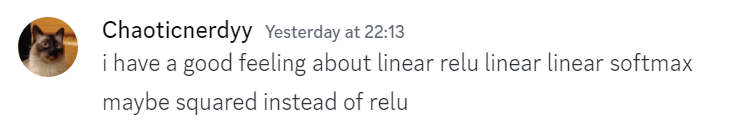

## Pitch NN
The cells in this section will define and test the feedforward neural network for fitting note pitches.

In [ ]:
#select your architecture by changing, adding or removing values between CAPACITY and UNIQUE_GENRES
arch_pNN = [CAPACITY, 64,64, UNIQUE_GENRES]

#select activations available under Neural Network Functions section
G_pNN = [Linear, Squared, Linear, Softmax]

#choose parameters for the pitch NN
alpha_pNN = 1e-5
momentum_pNN = .99
batch_size_pNN = 1700
lambda_pNN = 0.0006
max_iters_pNN = 300
cost_type_pNN = 'se'

W_pNN,B_pNN,costs_pNN,grad_norms_pNN = fit(X_pitches_train,y_train,arch_pNN,G_pNN,alpha_pNN, 
                                momentum_pNN,batch_size_pNN,lambda_pNN,max_iters_pNN,cost_type = cost_type_pNN)

The following cells can be used to evaluate performance on the pitch NN.

In [ ]:
print("Costs per batch")
plot_costs(costs_pNN)
print("Grad_norms cost per batch")
plot_costs(grad_norms_pNN)

In [ ]:
print("Accuracy on the train set:",accuracy(X_pitches_train,y_train,W_pNN,B_pNN,G_pNN))
print("Accuracy on the validation set:",accuracy(X_pitches_val,y_val,W_pNN,B_pNN,G_pNN))
print("Accuracy on the test set:",accuracy(X_pitches_test,y_test,W_pNN,B_pNN,G_pNN))

### Saving good architectures
Save your best architecture, activations, weights and biases.

In [ ]:
save(W_pNN,B_pNN,arch_pNN,G_pNN,'Pitch NN')

### Loading good architectures
Load the saved architecture, activations, weights and biases.

In [ ]:
W_pNN,B_pNN,arc_pNN,G_pNN = load('Pitch NN')

## Velocity NN
The cells in this section will define and test the feedforward neural network for fitting note velocities.

In [ ]:
#select your architecture by changing, adding or removing values between CAPACITY and UNIQUE_GENRES
arch_vNN = [CAPACITY, 120, 100, UNIQUE_GENRES]

#select activations available under Neural Network Functions section
G_vNN = [Linear, ReLU, ReLU, Softmax]

#choose parameters for the velocity NN
alpha_vNN = 0.05
momentum_vNN = .8
batch_size_vNN = 60
lambda_vNN = 0.00003
max_iters_vNN = 5000
cost_type_vNN = 'se'


W_vNN,B_vNN,costs_vNN,grad_norms_vNN = fit(X_velocities_train,y_train,arch_vNN,G_vNN,alpha_vNN, 
                                momentum_vNN,batch_size_vNN,lambda_vNN,max_iters_vNN,cost_type = cost_type_vNN)

The following cells can be used to evaluate performance on the velocity NN.

In [ ]:
print("Costs per batch")
plot_costs(costs_vNN)
print("Grad_norms cost per batch")
plot_costs(grad_norms_vNN)

In [ ]:
print("Accuracy on the train set:",accuracy(X_velocities_train,y_train,W_vNN,B_vNN,G_vNN))
print("Accuracy on the validation set:",accuracy(X_velocities_val,y_val,W_vNN,B_vNN,G_vNN))
print("Accuracy on the test set:",accuracy(X_velocities_test,y_test,W_vNN,B_vNN,G_vNN))

### Saving good architectures
Save your best architecture, activations, weights and biases.

In [ ]:
save(W_vNN,B_vNN,arch_vNN,G_vNN,'Velocity NN')

### Loading good architectures
Load the saved architecture, activations, weights and biases.

In [ ]:
W_vNN,B_vNN,arc_vNN,G_vNN = load('Velocity NN')

## Time Deltas NN
The cells in this section will define and test the feedforward neural network for fitting note time deltas.

In [ ]:
#select your architecture by changing, adding or removing values between CAPACITY and UNIQUE_GENRES
arch_tNN = [CAPACITY,20,20,18,UNIQUE_GENRES]

#select activations available under Neural Network Functions section
G_tNN = [Linear, ReLU,Linear, Linear, Softmax]

#choose parameters for the pitch NN
alpha_tNN = 1e-3
momentum_tNN = 0.9
batch_size_tNN = 1700
lambda_tNN = .000001
max_iters_tNN = 300
cost_type_tNN = 'se'

W_tNN,B_tNN,costs_tNN,grad_norms_tNN = fit(X_times_train,y_train,arch_tNN,G_tNN,alpha_tNN, 
                                momentum_tNN,batch_size_tNN,lambda_tNN,max_iters_tNN,cost_type = cost_type_tNN)

The following cells can be used to evaluate performance on the time deltas NN.

In [ ]:
print("Costs per batch")
plot_costs(costs_tNN)
print("Grad_norms cost per batch")
plot_costs(grad_norms_tNN)

In [ ]:
print("Accuracy on the train set:",accuracy(X_times_train,y_train,W_tNN,B_tNN,G_tNN))
print("Accuracy on the validation set:",accuracy(X_times_val,y_val,W_tNN,B_tNN,G_tNN))
print("Accuracy on the test set:",accuracy(X_times_test,y_test,W_tNN,B_tNN,G_tNN))

In [ ]:
os.chdir(WORKING_DIRECTORY)
mid = getMidiFile("La-La-La.mid")
print(mid)

### Saving good architectures
Save your best architecture, activations, weights and biases.

In [ ]:
save(W_tNN,B_tNN,arch_tNN,G_tNN,'Time Deltas NN')

### Loading good architectures
Load the saved architecture, activations, weights and biases.

In [ ]:
W_tNN,B_tNN,arc_tNN,G_tNN = load('Time Deltas NN')

# Music Generator
The cell below is the music generation algorithm. The method `generate` takes in a genre, a tolerance value, and parameters detailing note ranges, velocity ranges and time delta ranges. Run the cell below to get the neccessary functions for it.

In [ ]:
def attributeAccuracy(messageList, genre, attribute):
    if attribute == 'notes':
        vector = getNotesFromList(messageList)
        W,B,G = W_pNN, B_pNN, G_pNN
        
    elif attribute == 'velocities':
        vector = getVelocitiesFromList(messageList)
        W,B,G = W_vNN, B_vNN, G_vNN
        
    elif attribute == 'times':
        vector = getTimesFromList(messageList)
        W,B,G = W_tNN, B_tNN, G_tNN
        
    else:
        print("Provide a valid attribute value.")
        
    probability = feedforward(W,B,G,vector)[-1]
    correctIndex = np.argmax(encoder(genre))
    
    return probability[correctIndex]        

def generate(notesList, genre, tolerance, lowPitch, hiPitch, lowVel, hiVel, lowTimes, hiTimes):
    generatedOutput = notesList
    
    emptyNote = mido.Message('note_on')
    accuracy = 0
    i = len(notesList)
    
    for j in range(i,CAPACITY):
        generatedOutput.append(emptyNote)
    
    while accuracy < tolerance and i < len(generatedOutput):
        #between A1 and G6
        pitch_pool = [*range(lowPitch,hiPitch)]
        #between piano and fortissimo
        velocity_pool = [*range(lowVel,hiVel)]
        #between semiquaver and semibreve
        times_pool = [*range(lowTimes,hiTimes)]
        
        bestPitchAccuracy = 0
        bestVelocityAccuracy = 0
        bestTimesAccuracy = 0
        
        #new pitch
        for itemInPitchPool in pitch_pool:
            generatedOutput[i] = generatedOutput[i].copy( note = itemInPitchPool )
            pitchAcc = attributeAccuracy(generatedOutput,genre, 'notes')
            if pitchAcc > bestPitchAccuracy:
                bestPitchAccuracy = pitchAcc
                bestPitch = itemInPitchPool
        generatedOutput[i] = generatedOutput[i].copy(note=bestPitch)
        
        #associated velocity
        for itemInVelocityPool in velocity_pool:
            generatedOutput[i] = generatedOutput[i].copy(velocity=itemInVelocityPool)
            velocityAcc = attributeAccuracy(generatedOutput,genre, 'velocities')
            if velocityAcc > bestVelocityAccuracy:
                bestVelocityAccuracy = velocityAcc
                bestVelocity = itemInVelocityPool
        generatedOutput[i] = generatedOutput[i].copy(velocity=bestVelocity)
        
        #associated time delta
        for itemInTimesPool in times_pool:
            generatedOutput[i] = generatedOutput[i].copy(time=itemInTimesPool)
            timesAcc = attributeAccuracy(generatedOutput,genre, 'times')
            if timesAcc > bestTimesAccuracy:
                bestTimesAccuracy = timesAcc
                bestTime = itemInTimesPool
        generatedOutput[i] = generatedOutput[i].copy(time=bestTime)
        
        
        i += 1
        
        accuracy = (bestPitchAccuracy+bestVelocityAccuracy+bestTimesAccuracy)/3
    return generatedOutput

## Generate something!
In the immediate cell below, edit some values and run it to generate a .mid file! Depending on `CAPACITY`, this will take a while. For a capacity of 256, this takes 3 minutes.

In [ ]:
from mido import Message, MidiFile, MidiTrack


####################EDIT THESE PARAMETERS####################
genre = 'Soundtracks'
tolerance = 1

lowest_pitch = 21 #A1 on a piano
highest_pitch = 108 #C8 on a piano

quietest_note = 33 #pianissimo
loudest_note = 127 #fortissimo

slowest_note = 1808 #semibreve (whole note)
fastest_note = 113 #semiquaver (sixteenth note)
###################################################




out = generate([], genre, tolerance, lowest_pitch, highest_pitch, quietest_note, loudest_note, fastest_note, slowest_note)

os.chdir(WORKING_DIRECTORY)
os.chdir('..')
os.chdir(os.getcwd() + "\\" + "Output")

mid = MidiFile()
track = MidiTrack()

for msg in out:
    track.append(msg)
    
mid.tracks.append(track)

mid.save('output_song.mid')
print("Saved output_song.mid to " + os.getcwd())

# Remarks
The output should resemble the correct genre as close as the given `tolerance`. Better NN models will yield better results. This algorithm works by going through every possible pitch, velocity and time delta per note event, and selecting the best pitch, velocity and time delta in that note event according to the best probabilty to the given `genre`. With the best possible values, it moves on to the next note event and repeats.

This process will always reproduce the same output for a given genre, since it is synthesizing the trained dataset, but higher validation accuracies will make the genre more distinguishable. However, you can also use it to complete an incomplete .mid track, as long as it is under `CAPACITY`. To do this, follow the instructions below.

Firstly, save your .mid file anywhere under the directory \Data. Then modify the value of `name_of_your_midi_file` to the appropriate filename, making sure it is a string that ends in .mid. Afterwards, just run the cell, and expect a good output in the \Output folder!

In [ ]:
name_of_your_midi_file = ''



###############################################
os.chdir(WORKING_DIRECTORY)
mid = MidiFile(name_of_your_midi_file, clip = True)
notesList = getNotes(mid,0)

if len(notesList) > CAPACITY:
    print("Your .mid file is larger than CAPACITY, so this generator won't do anything.")
else:
    out = generate(notesList, 'Classical', tolerance, lowest_pitch, highest_pitch, quietest_note, loudest_note, fastest_note, slowest_note)
    
    os.chdir(WORKING_DIRECTORY)
    os.chdir('..')
    os.chdir(os.getcwd() + "\\" + "Output")

    mid = MidiFile()
    track = MidiTrack()

    for msg in out:
        track.append(msg)

    mid.tracks.append(track)

    mid.save('completion_song.mid')
    print("Saved completion_song.mid to " + os.getcwd())